In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df=pd.read_csv('/kaggle/input/fast-food-chains-nutrition-values/nutrition_values.csv',sep=';')
df.fillna(value=0, inplace=True)
df.replace({'-':int(0), ',':'.'}, inplace=True,regex=True)
df=pd.concat([df.iloc[:,0:3],df.iloc[:,3:15].astype(float)],axis=1)

# <p style = "font-family:palatino linotype,serif;font-size:25px;">Intro: healthiness and nutritious </p>
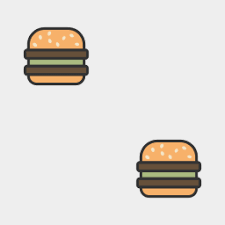
<ol style = "font-family:palatino linotype,serif;font-size:16px;">
As we know, all food contains carbohydrates, fats and proteins. These components describe the nutritional value, whereas quantitively we can describe it with calories. If we talk about healthiness of fast food, we should take into account: 
<li> sugar level (the main cause of obesity, the normal range is 25-38 g per day, I will take in the middle - 31.5)</li>
<li> trans fat level (increase risk of heart disease, range: no more than 1% of total calories per day, what if we have only fast food whole day? Then it must be no more than 1% of total calories of a dish)</li>
<li>  saturated fat (no more than 10% of total calories)</li>
<li>  dietary fibre (should be at least 14g/1000 calories)</li>
<li> calories from fats should be no more 25-30% of total calories</li>
<li>  sodium (the dietary guidelines recommend no more than 2.3 g per day)</li>
<li>  there is no evidence that increased cholesterol in the diet can affect human health</li>
<li>  protein level (contribute to muscle growth, high intake of protein benefits for bodyweight loss)</li> 

Keep in mind that these recommendations address to healthy people, who do not have diabetes or cardiovascular diseases. So, let's filter our dishes according to these parameters and see what we've got.
</ol> 

<p style = "font-family:palatino linotype,serif;font-size:25px;">
        Here are formulas I used for calculations (I used an approximation that all fats have have the same contribution to calories, and, of course, dietary fibres must be more than 14g/1000 calories, it's a typo)
      </p>
<a href="https://ibb.co/w4rZByn"><img src="https://i.ibb.co/1TJY7ZC/Untitled.png" alt="Untitled" border="0"></a>

In [ ]:
sugar_safe=df[df['Total Sugar (g)']<=31.5] #317
too_much_sugar=df[df['Total Sugar (g)']>=31.5] #182

#sorry, this is only trans fat filter, I named this variable not very clear 
fat_safe=sugar_safe[(sugar_safe['Trans Fat (g)']/sugar_safe['Total Fat (g)'])*sugar_safe['Calories from fat']<=sugar_safe['Calories']*0.01] #199
fat_much=sugar_safe[(sugar_safe['Trans Fat (g)']/sugar_safe['Total Fat (g)'])*sugar_safe['Calories from fat']>=sugar_safe['Calories']*0.01] #43

saturated_fat_safe=fat_safe[(fat_safe['Saturated Fat (g)']/fat_safe['Total Fat (g)'])*fat_safe['Calories from fat']<=fat_safe['Calories']*0.1] #66
saturated_fat_much=fat_safe[(fat_safe['Saturated Fat (g)']/fat_safe['Total Fat (g)'])*fat_safe['Calories from fat']>fat_safe['Calories']*0.1] #133

fiber_good=saturated_fat_safe[(saturated_fat_safe['Dietary Fiber (g)']*1000/saturated_fat_safe['Calories'])>=14] # 9, in most of the cases dietary fiber is not enough 
fiber_not_enough=saturated_fat_safe[(saturated_fat_safe['Dietary Fiber (g)']*1000/saturated_fat_safe['Calories'])<14] #57

totalfat_safe=saturated_fat_safe[saturated_fat_safe['Calories from fat']/saturated_fat_safe['Calories']<=30] # all passed this filter
totalfat_much=saturated_fat_safe[saturated_fat_safe['Calories from fat']/saturated_fat_safe['Calories']>30]

sodium_safe=totalfat_safe[totalfat_safe['Sodium (mg)']<=2300] # they all passed it too 
sodium_much=totalfat_safe[totalfat_safe['Sodium (mg)']>2300]

<p style = "font-family:palatino linotype,serif;font-size:25px;"> So, we can see that only 66 items out of 499 could pass these filters (dietary fiber filter not included) and several of them unfortunately do not have names. Check it out: </p>

In [ ]:
#let's add a column with a protein normalization per gram of the portion
sodium_safe=sodium_safe[sodium_safe['Serving Size (g)']!=0]
sodium_safe=sodium_safe[sodium_safe['Item']!=0]        
sodium_safe['Protein (g)/g of portion']=sodium_safe['Protein (g)']/sodium_safe['Serving Size (g)']

import matplotlib.pyplot as plt
plt.figure()
plt.rcParams.update({'font.size': 12})
sodium_safe.sort_values(by='Protein (g)/g of portion').plot.barh(x='Item',y='Protein (g)/g of portion', figsize=(15,15), stacked=True)

<p style = "font-family:palatino linotype,serif;font-size:25px;"> ...And only 9 are good enough in terms of amount of dietary fiber as well: </p>

In [ ]:
#let's add a column with a protein normalization per gram of the portion
fiber_good=fiber_good[fiber_good['Serving Size (g)']!=0]
fiber_good=fiber_good[fiber_good['Item']!=0]        
fiber_good['Protein (g)/g of portion']=fiber_good['Protein (g)']/fiber_good['Serving Size (g)']


fiber_good.sort_values(by='Protein (g)/g of portion').plot.barh(x='Item',y='Protein (g)/g of portion', figsize=(15,15), stacked=True)

# <p style = "font-family:palatino linotype,serif;font-size:25px;"> ..And what about their calories? </p>

In [ ]:
#let's add a column with a calories normalization per gram of the portion
fiber_good['Calories/g of portion']=fiber_good['Calories']/fiber_good['Serving Size (g)']

fiber_good.sort_values(by='Calories').plot.barh(x='Item',y='Calories', figsize=(15,15), stacked=True)

 <p style = "font-family:palatino linotype,serif;font-size:25px;"> So, in terms of healthiness & amount of protein the dish "Peanuts" from Mc Donalds is the winner and in terms of healthiness & calories the winner is "Premium Southwest Salad with Grilled Chicken" from Mc Donalds	as well </p>

# <p style = "font-family:palatino linotype,serif;font-size:25px;"> Let's move on and check how much sugar and trans and saturated fats on average are contained fast food dishes </p> 

In [ ]:
# Feature engineering
# look, a new feature engeneered for the whole dataset, more than 1% is bad 
df['Calories from trans fat / Total Calories']=100*df['Calories from fat']/df['Calories']
# and another one, more than 10% is bad
df['Calories from saturated fat / Total Calories']=100*(df['Saturated Fat (g)']/df['Total Fat (g)'])*(df['Calories from fat']/df['Calories'])
# dietory fibre/total calories
df['Dietary fiber/ 1000 calories']= df['Dietary Fiber (g)']*1000/df['Calories']

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
fig = make_subplots(rows=2, cols=2)

trace0=go.Histogram(x=df['Total Sugar (g)'], name='Total Sugar (g) (>31.5 is over threshold)', nbinsx=15)
trace1=go.Histogram(x=df['Calories from trans fat / Total Calories'], name='Calories from trans fat / Total Calories (>1% is over threshold)',nbinsx=100)
trace2=go.Histogram(x=df['Calories from saturated fat / Total Calories'],name='Calories from saturated fat / Total Calories (>10% is over threshold)', nbinsx=100)
trace3=go.Histogram(x=df['Dietary fiber/ 1000 calories'], name='Dietary fibre/ 1000 calories (<14 g is not good)')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.update_layout(width=600, height=500, legend=dict(
    yanchor="top",
    y=1.4,
    xanchor="left",
    x=0.01
))

fig.show()

<p style = "font-family:palatino linotype,serif;font-size:25px;"> All in all, whilst fast food industry has been put a lot of efforts to make their food more healthy, still, we can see a big bias toward trans & saturated fats and sugar, and only a few items contained enough dietary fiber. </p>

![](https://media.giphy.com/media/3o6ozuHcxTtVWJJn32/giphy.gif)